# Classification of Heart Disease Using K-Nearest Neighbor

In [2]:
# Load packages.
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(gridExtra)

## Introduction
Many people die of cardiovascular diseases without knowing they have a problem with their heart. Unexpected deaths can be prevented with early diagnosis of cardiovascular issues and proper medication. When a patient comes to the hospital, there are many pieces of data such as symptoms, test results, and personal information that can help cardiologists predict if heart disease is present. In this project, we are trying to answer: **Can existing cardiovascular patient data** (specifically, `age`, `ca`, `cp`, `oldpeak`, `restecg`, `slope`, `thal` and `thalach` in the dataset) **and the KNN classification algorithm be used to detect the presence or absence of heart disease in new patients entering the hospital? How accurate could it be, and how can we apply it correctly in practice?** The heart [disease dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) we are using is obtained from the UCI machine learning repository. It contains 303 patient instances and 14 attributes collected from Cleveland. Each row of the dataset corresponds to one patient's personal and medical information upon entry to the hospital. 

This original dataset contains the following variables: 
- `sex`: 1 = male; 0 = female
- `cp`: chest pain type (1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic); 
- `trestbps`: resting blood pressure (in mm Hg on admission to hospital); 
- `chol`: serum cholesteral in mg/dl; 
- `fbs`: fasting blood sugar > 120 mg/dl (1 = true, 2 = false); 
- `restecg`: resting electrocardiographic results (0 = normal; 1 = having ST-T wave abnormality; 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria); 
- `thalach`: maximum heart rate achieved; 
- `exang`: exercise induced angina (1 = yes, 0 = no); 
- `oldpeak`: ST depression induced by exercise relative to rest; 
- `slope`: the slope of the peak exercise ST segment (1 = upsloping, 2 = flat, 3 = downsloping); 
- `ca`: number of major vessels (0-3) colored by flourosopy; 
- `thal`: type of defect (3 = normal, 6 = fixed defect, 7 = reversable defect); 
- `num`: diagnosis of heart disease (angiographic disease status) (0 = absence, 1, 2, 3, 4 = presence)

Our target variable would be `num`, which we later renamed as `diagnosis`. We selected `age`, `ca`, `cp`, `oldpeak`, `restecg`, `slope`, `thal` and `thalach` as predictors to determine heart disease status.

## Methods and Results
### 1. Read the Original Dataset on the Web

In [3]:
# Set the value of seed to ensure reproducibility
set.seed(200)

# Read the dataset from the web into a tibble dataframe
url <- 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
heart_cleve <- read_csv(url,col_names = FALSE)
head(heart_cleve)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


*Table 1: Original dataset (only showing the first 6 rows)*

### 2. Data Wrangling
> The columns must be renamed from the placeholders that R created to meaningful and human-readable names . Here, we replaced them with the same names used in the original dataset, except `diagnosis` for ease, which was initially called `num`.
Additionally, `ca` and `thal` were converted to numeric values for use in the KNN algorithm.

In [4]:
# Rename the column names and Format the column types
heart_cleve <- rename(heart_cleve, age = X1,
               sex = X2,
               cp = X3,
               trestbps = X4,
               chol = X5,
               fbs = X6,
               restecg = X7,
               thalach = X8,
               exang = X9,
               oldpeak = X10,
               slope = X11,
               ca = X12,
               thal = X13,
               diagnosis = X14) %>% 
            mutate(ca = as.numeric(ca),thal = as.numeric(thal))
# head(heart_cleve)

Warning message:
“Problem with `mutate()` input `ca`.
ℹ NAs introduced by coercion
ℹ Input `ca` is `as.numeric(ca)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `thal`.
ℹ NAs introduced by coercion
ℹ Input `thal` is `as.numeric(thal)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


> The column `diagnosis` originally had the values 0-4. However, we are looking at the presence versus absence of heart disease, requiring only two values. We wrangled the data so that 0 indicates the absence of heart disease and 1 indicates the presence of heart disease.

In [5]:
# Wrangle the `diagnosis` column: 0 indicates absence of heart disease and 1 indicates presence of heart disease.

heart_cleve$diagnosis[heart_cleve$diagnosis==2] <- 1
heart_cleve$diagnosis[heart_cleve$diagnosis==3] <- 1
heart_cleve$diagnosis[heart_cleve$diagnosis==4] <- 1
heart_cleve <- heart_cleve %>% mutate(diagnosis = as_factor(diagnosis))
head(heart_cleve)

# Source: https://www.geeksforgeeks.org/how-to-replace-specific-values-in-column-in-r-dataframe/

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0


*Table 2: Data table after wrangling (only showing the first 6 rows)*

### 3. Data Splitting
The data is split into training and testing sets so that we can explore the data and train the model without compromising the accuracy prediction of our model.

In [7]:
set.seed(200)

# Split the dataset into training and testing sets

heart_split <- initial_split(heart_cleve, prop = 0.75, strata = diagnosis)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

### 4. Exploratory Data Analysis and Predictor Selection
The training data is used to explore specific patterns and characteristics of the data before making any assumptions and building the model. It also helps to determine if additional steps are needed to wrangle the data and helps with our predictor selection.   
#### Summary Statistics of the Training Data
> The table below shows a relatively balanced distribution of the observations for the two diagnoses. Therefore, no further steps were taken to balance them.

In [8]:
# Number of observations in each class
heart_sum_class <- heart_train %>% 
                group_by(diagnosis) %>%
                summarise(n=n(), percent=n()/nrow(heart_train)*100)
heart_sum_class

`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,n,percent
<fct>,<int>,<dbl>
0,123,53.94737
1,105,46.05263


*Table 3: Number of and percentage of observations in each class*

> The following table gives us a thorough overview of the variables we are working with. It can help us understand the predictors we would be using and whether we need to do further wrangling.

In [9]:
# Summary statistics of predictor variables used in analysis
options(digits=2)
heart_percentile <- heart_train %>%
                    select(-diagnosis) %>%
                    map_df(quantile,na.rm = TRUE) 

heart_1stQ <- heart_percentile %>%
                select('25%') %>%
                t()%>%
                as.vector()

heart_3rdQ <- heart_percentile %>%
                select('75%') %>%
                t() %>%
                as.vector()

heart_mean <- heart_train%>% 
                    select(-diagnosis) %>%
                    map_df(mean,na.rm = TRUE)

heart_min <- heart_train %>%
                    select(-diagnosis) %>%
                    map_df(min,na.rm = TRUE)

heart_max <- heart_train %>%
                    select(-diagnosis) %>%
                    map_df(max,na.rm = TRUE)

heart_median <- heart_train %>%
                    select(-diagnosis) %>%
                    map_df(median,na.rm = TRUE)

heart_range <- heart_max - heart_min

heart_missing <- colSums(is.na(heart_train %>% select(-diagnosis)))
# Source: https://stackoverflow.com/questions/26273663/r-how-to-total-the-number-of-na-in-each-col-of-data-frame

heart_sum_pred <- rbind(heart_min, heart_1stQ, heart_median,heart_mean, heart_3rdQ, heart_max, heart_range, heart_missing) %>%
                    mutate(Statistics = c('Min','First Quartile','Median','Mean','Third Quartile','Max','Range','# of Missing Value'),.before = age)
heart_sum_pred

Statistics,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Min,29,0.00,1.0,94,126,0.00,0,71,0.00,0.00,1.0,0.00,3.0
First Quartile,48,0.00,3.0,120,210,0.00,0,139,0.00,0.00,1.0,0.00,3.0
Median,56,1.00,3.5,130,238,0.00,1,154,0.00,0.75,2.0,0.00,3.0
Mean,55,0.67,3.2,132,245,0.14,1,150,0.33,1.01,1.6,0.64,4.7
Third Quartile,61,1.00,4.0,140,274,0.00,2,168,1.00,1.60,2.0,1.00,7.0
Max,77,1.00,4.0,200,564,1.00,2,202,1.00,6.20,3.0,3.00,7.0
Range,48,1.00,3.0,106,438,1.00,2,131,1.00,6.20,2.0,3.00,4.0
# of Missing Value,0,0.00,0.0,0,0,0.00,0,0,0.00,0.00,0.0,3.00,2.0


*Table 4: Summary statistics of variables in the training set*

> We have a relatively broad age range, indicating the representativeness of the data. What should be noted is both `ca` and `thal` have missing values. If we were to use them as predictors, wrangling steps would be needed to discard corresponding observations.

#### Visualization of the Training Data
> A density plot is used to visualize the training data and to help with predictor selection. We know that less overlap between different classes on the density curve would imply better prediction power of a variable, as every numeric value more closely belongs to a specific class.

Warning message:
“Removed 5 rows containing non-finite values (stat_density).”


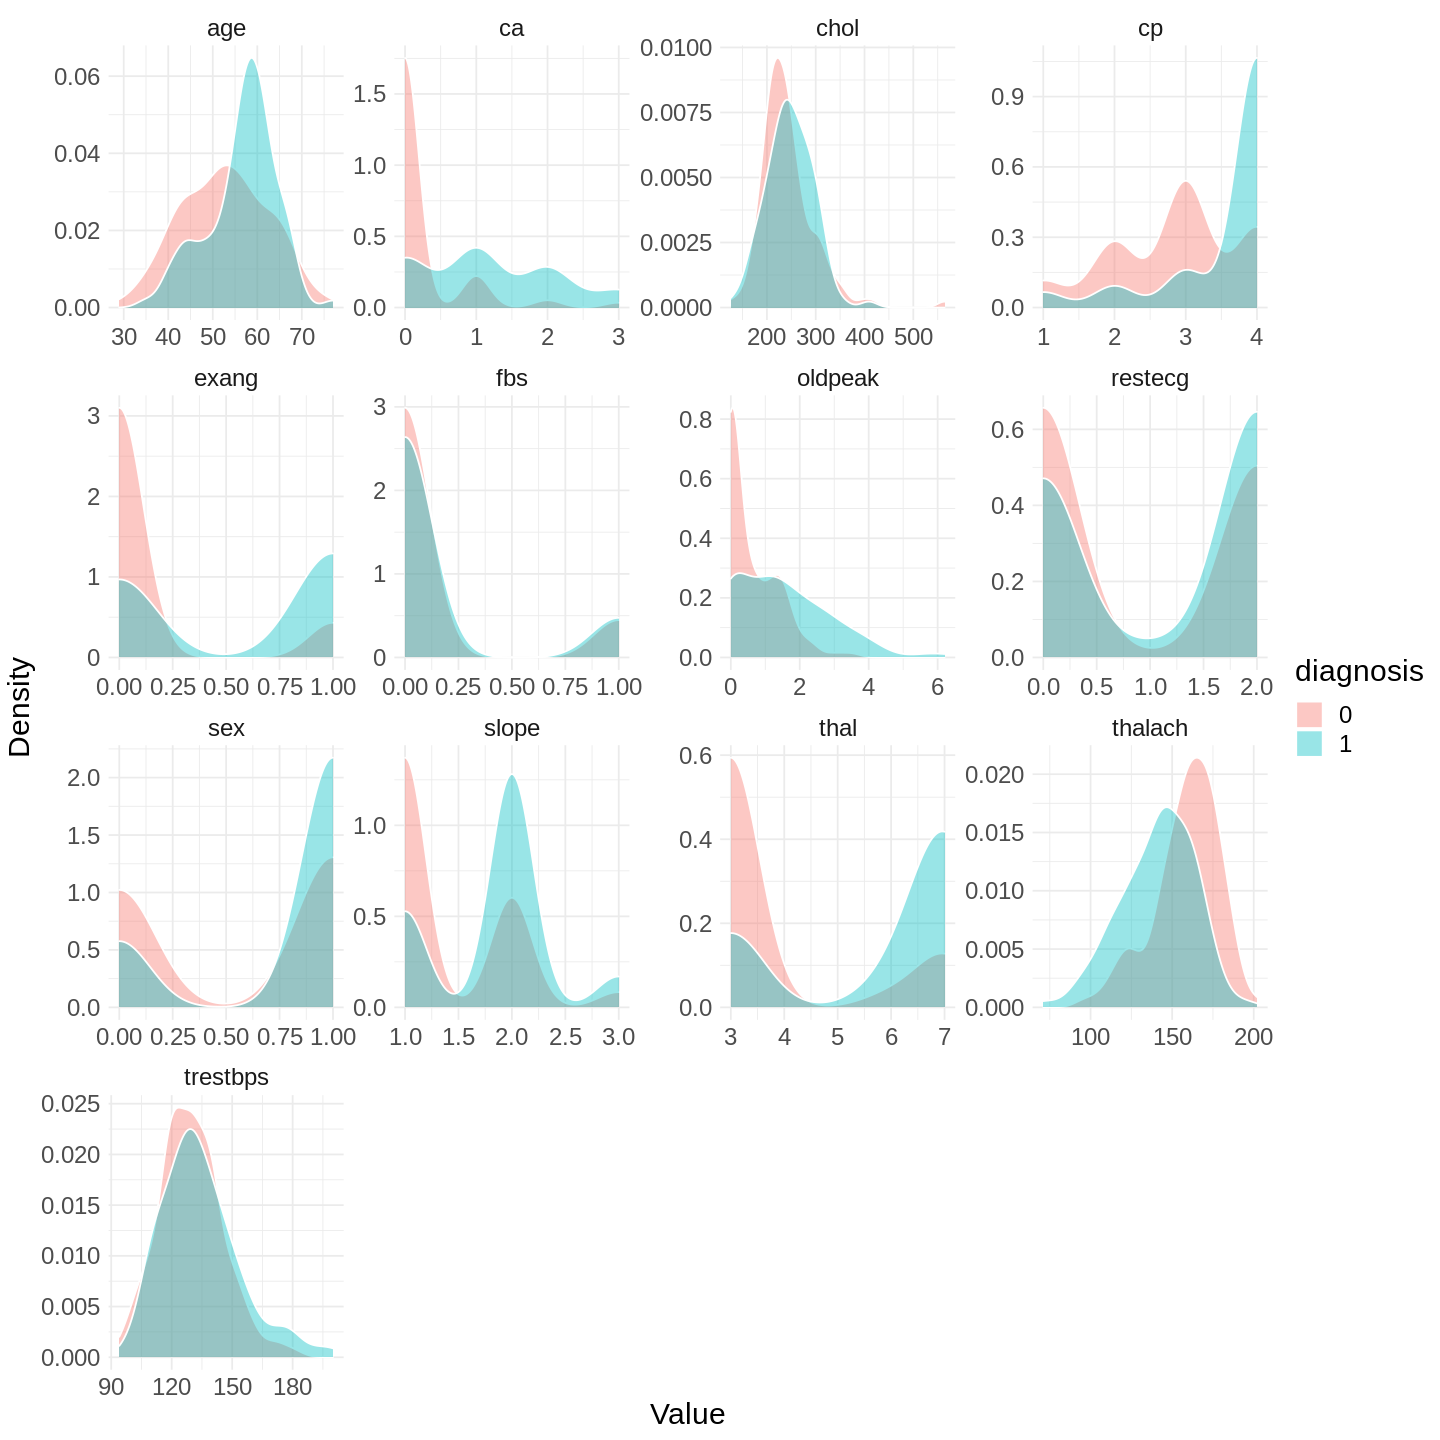

In [15]:
options(repr.plot.width=12,repr.plot.height = 12)
heart_train %>%
    pivot_longer(cols = -diagnosis, names_to = 'variables', values_to = 'value')  %>% 
    ggplot(aes(value, fill = diagnosis)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(~ variables, scales = 'free') +
        theme_minimal() +
        theme(text = element_text(size = 18)) +
        labs(x='Value', y='Density')

*Figure 1: Density plots of all variables in the training set*

According to the density plots and literature review on heart disease, we chose `age`, `ca`, `cp`, `oldpeak`, `restecg`, `slope`, `thal` and `thalach` as our predictors. The density plots of the majority of these variables show a relatively more distinct distribution between classes, indicating them as better predictors of heart disease diagnosis than others. Although the distribution of both classes regarding the `restecg` variable is quite similar, `restecg` (resting electrocardiographic results) is selected as a reliable predictor because it can detect heart problems by measuring electrical activity when the heart contracts (Ashley et al., 2001).


> Since both `ca` and `thal` have missing values (according to *Table 4*), wrangling is needed to filter out the observations with missing values in both the training and test sets.

In [16]:
# Filter out observations with missing values
heart_train_filtered <- heart_train %>% filter(!is.na(ca)) %>% filter(!is.na(thal))
heart_test_filtered <- heart_test %>% filter(!is.na(ca)) %>% filter(!is.na(thal))

# heart_train_filtered
# heart_test_filtered


### 5. Model Training and Model Tuning using Cross-validation

Next, we will determine the optimal K value to achieve maximum accuracy through a methodical approach outlined below.

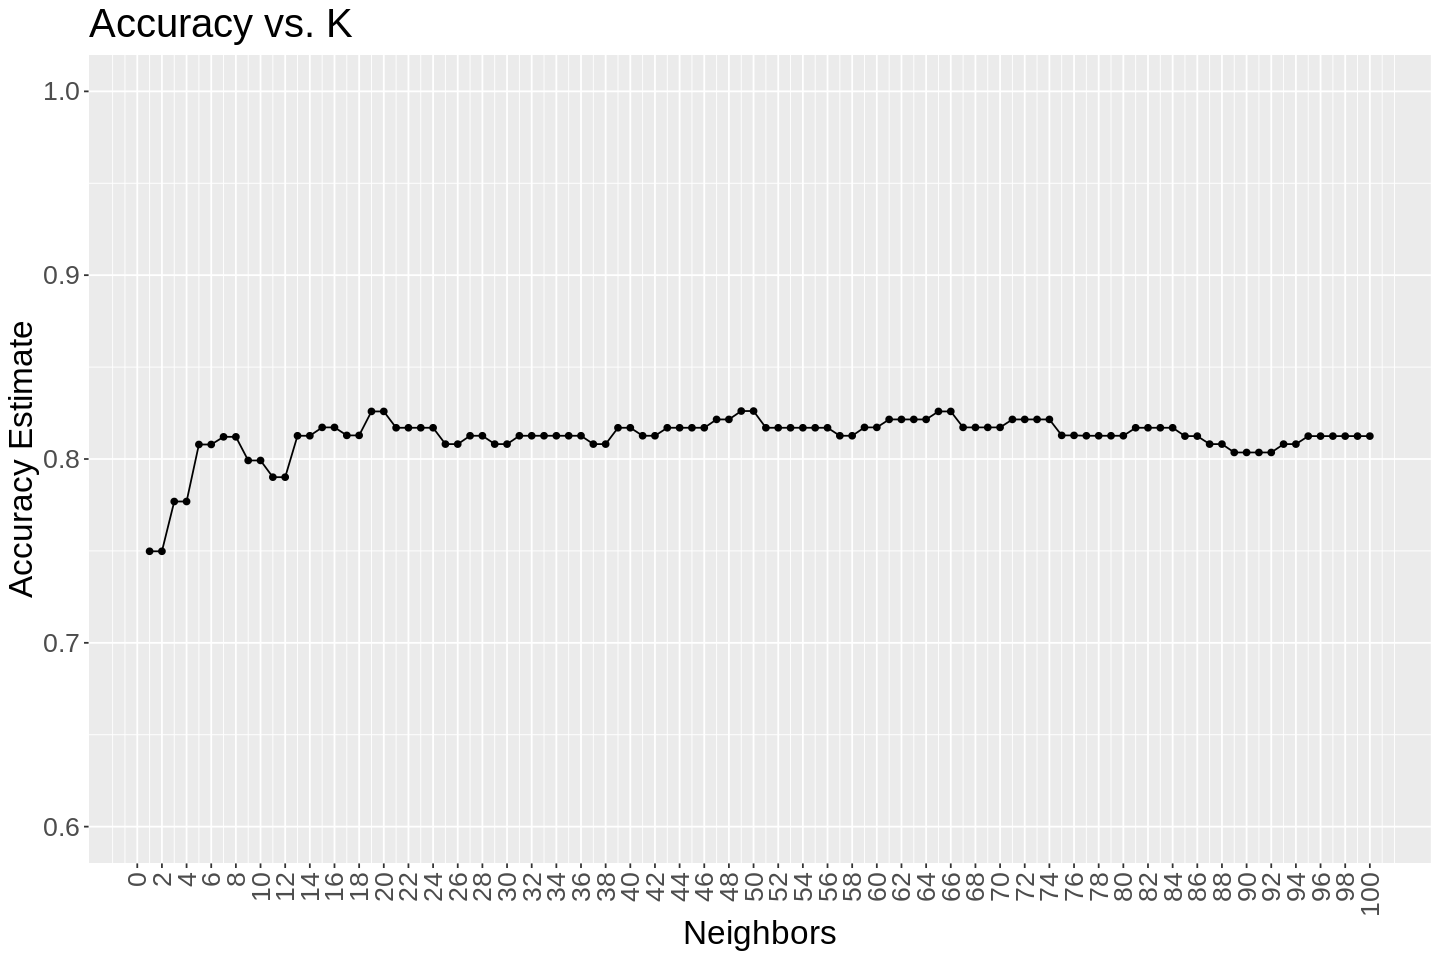

In [17]:
set.seed(200)
# Create the recipe that specifies class label and predictors, as well as preprocessing steps for all variables.
heart_recipe <- recipe(diagnosis ~ age + ca + cp + oldpeak + restecg + slope + thal+ thalach, data = heart_train_filtered) %>%
                    step_scale(all_predictors()) %>%
                    step_center(all_predictors())
# heart_recipe


# Create a KNN model specification
heart_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                    set_engine("kknn") %>%
                    set_mode("classification")
# heart_tune


# Split the training data for cross-validation
heart_vfold <- vfold_cv(heart_train_filtered, v = 10, strata = diagnosis)


# Create a dataframe with a neighbors variable that contains the sequence of values of K to try
k_vals <- tibble(neighbors=seq(from = 1, to = 100, by = 1))


# Create a workflow to train KNN classifiers and estimate the classifier accuracy for a range of K values.
heart_results <- workflow() %>%
                    add_recipe(heart_recipe) %>%
                    add_model(heart_tune) %>%
                    tune_grid(resamples = heart_vfold, grid = k_vals) %>%
                    collect_metrics()
# heart_results


# Filter the accuracy metric of classifers trained with different value of K
accuracies <- heart_results %>%
                    filter(.metric == "accuracy")
# head(accuracies)


# Create a plot for accuracy vs. K
options (repr.plot.width = 12, repr.plot.height = 8)
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 100, by = 2)) +  
      scale_y_continuous(limits = c(0.6, 1.0), breaks = seq (0.4, 1, by = 0.1)) +
      theme(text = element_text(size = 20),axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
      ggtitle('Accuracy vs. K')
accuracy_vs_k

*Figure 2: Estimated prediction accuracy for each value of K (number of neighbors)*

#### 6. Model Testing and Performance Evaluation

Finally, we use the optimal K value obtained above to test our model against the testing data. The accuracy output will indicate how good the classifier is and whether it is practical to use it in a healthcare setting where the diagnosis of heart disease would be an urgent and vital conclusion that requires high accuracy.

In [20]:
# Pulling the optimal value of K
best_k <- accuracies %>%
            filter(mean==max(mean))%>%
            slice(1) %>%
            pull(neighbors)
# print(best_k)


# Create a KNN model specification with the optimal K
heart_best <- nearest_neighbor (weight_func = 'rectangular', neighbors = best_k) %>%
                set_engine ('kknn') %>%
                set_mode ('classification')
# heart_best

# Create a workflow to train KNN classifiers
heart_fit <- workflow () %>%
                add_recipe (heart_recipe) %>%
                add_model (heart_best) %>%
                fit (data = heart_train_filtered)
# heart_fit


# Predict the labels of the test set
heart_diagnosis_pred <- predict(heart_fit, heart_test_filtered) %>%
                            bind_cols(heart_test_filtered) 


# Collect evaluation metrics -- Accuracy
heart_accuracy <- heart_diagnosis_pred %>%
                        metrics(truth = diagnosis, estimate = .pred_class)%>%
                        filter(.metric == 'accuracy') %>%
                        select(.estimate) %>%
                        pull()




# Present the Confusion Matrix
confusion <- heart_diagnosis_pred %>%
                conf_mat(truth = diagnosis, estimate = .pred_class)


paste('The optimal K value is:', as.character(best_k))
paste("The estimated Accuracy is:", as.character(heart_accuracy))
paste("Confusion Matrix:")
confusion

[1] "The optimal K value is: 49"

[1] "The estimated Accuracy is: 0.878378378378378"

[1] "Confusion Matrix:"

          Truth
Prediction  0  1
         0 38  7
         1  2 27

#### 7. Visualizing the Predition Results
Since humans register data well visually, we have plotted our prediction assignment.

In [21]:
# To add an index column to the data frame.
heart_diagnosis_pred$index <- 1:nrow(heart_diagnosis_pred)
head(heart_diagnosis_pred)

# Source: https://www.statology.org/add-index-column-to-data-frame-r/

.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis,index
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<int>
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1,1
0,66,0,1,150,226,0,0,114,0,2.6,3,0,3,0,2
0,69,0,1,140,239,0,0,151,0,1.8,1,2,3,0,3
0,64,1,3,140,335,0,0,158,0,0.0,1,0,3,1,4
0,44,1,3,130,233,0,0,179,1,0.4,1,0,3,0,5
0,61,1,3,150,243,1,0,137,1,1.0,2,0,3,0,6


*Table 5: Data table with an index column*

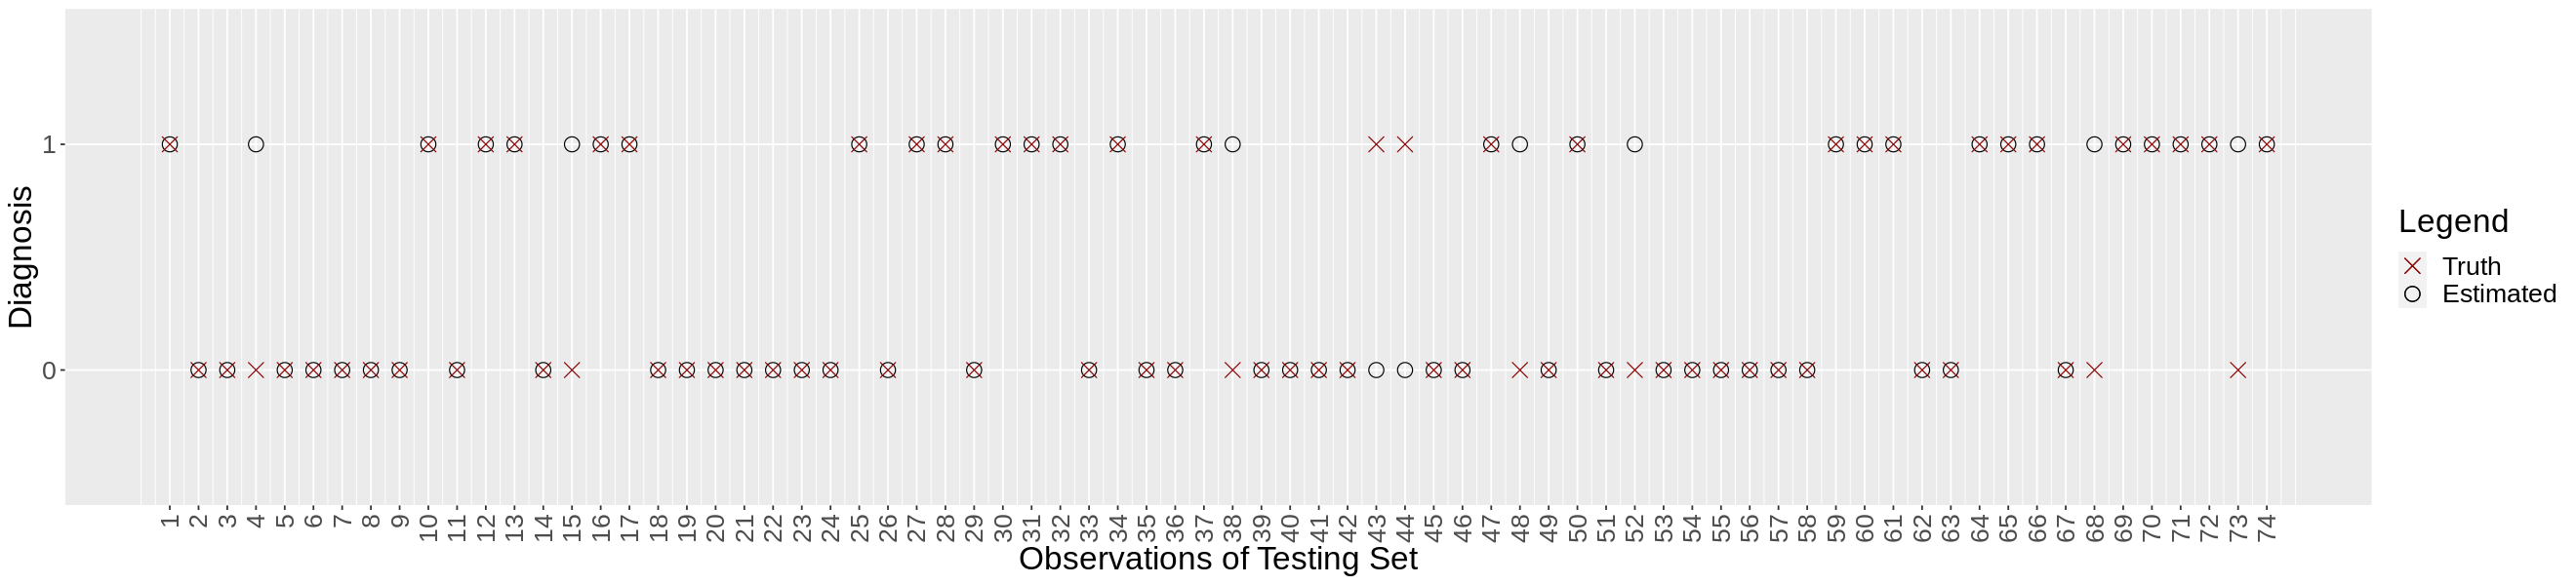

In [22]:
options(repr.plot.width=22,repr.plot.height=5)

colors <- c("Truth" = "black", "Estimated" = "#8B0000")
shapes <- c("truth" = 1, "estimated" = 4)
mapping <- ggplot(heart_diagnosis_pred,aes(x=index)) +
            geom_point(aes(y=diagnosis, color= 'Truth',shape='truth'),size=4)+
            geom_point(aes(y=.pred_class, color='Estimated',shape='estimated'),size=4)+
            scale_x_continuous(breaks=1:nrow(heart_diagnosis_pred)) +
            labs(x='Observations of Testing Set',y='Diagnosis',shape="",color="")+
            scale_color_manual(name="Legend", labels=c("Truth","Estimated"),values=colors)+
            scale_shape_manual(name="Legend", labels=c("Truth","Estimated"),values=shapes)+
            theme(text=element_text(size=20), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
mapping

# Source: 
# http://www.sthda.com/english/wiki/r-plot-pch-symbols-the-different-point-shapes-available-in-r
# https://stackoverflow.com/questions/12410908/combine-legends-for-color-and-shape-into-a-single-legend
# https://community.rstudio.com/t/adding-manual-legend-to-ggplot2/41651/4

*Figure 3: Visulization of prediction results*

## Discussion
We created a KNN classifier to predict the presence or absence of heart disease using existing data from cardiovascular patients. The optimal classifier uses a K value of 49 with `age`, `ca`, `cp`, `oldpeak`, `restecg`, `slope`, `thal` and `thalach` as predictors. It has an estimated accuracy of around 87.8%, which is an mediocre one considering the fatal consequences of wrong predictions, especially in the case of predicting actual presence as absence (*Type 2 Error*). As the confusion matrix shows, the classifier performs well on addressing *Type 1 Error* but relatively poorly on addressing *Type 2 Error*. This constitutes one of our primary concerns since the costs of *Type 2 Error* in the case of heart disease diagnosis would be much higher than that of *Type 1 Error*. Thus, we would expect future research to find ways to incorporate prediction error costs when finding the optimal K value or when using an algorithm other than KNN. There exist other limitations in the current research. Firstly, using the distance-based KNN classification algorithm means significant complexity to incorporate categorical variables as predictors. The values manually assigned to each class of a variable would fundamentally influence the final model. Second, there is a limited number of variables to consider in predictor selection, specifically quantitative ones.  

Despite the limitations, we are optimistic about what we found that cardiovascular data can help with heart disease diagnosis. Many possible improvements can be made to these limitations in future research, which may bring new insights into this area. Still, we wouldn't expect the classifier to deliver perfect predictions. Instead, it should be used to build decision support systems to facilitate clinicians' diagnoses and precautionary treatment decisions. In the future, it would be helpful to ask what other numerical variables could be used as solid predictors for heart disease? What would be better value assignments to categorical variables that have literature-supported strong prediction power? How can we incorporate prediction error costs to decrease *Type 2 Error*? 






## References

Ashley, E. A., Raxwal, V., & Froelicher, V. (2001, August 1). An evidence-based review of the resting electrocardiogram as a screening technique for heart disease. ScienceDirect. https://www.sciencedirect.com/science/article/pii/S0033062001000196

Pedoe, H. D. (1978, June 1). Predictability of sudden death from resting electrocardiogram. Effect of previous manifestations of coronary heart disease. Heart. https://heart.bmj.com/content/40/6/630.short